In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
train = pd.read_csv('data/train.csv', header = None)
test = pd.read_csv('data/test.csv', header = None)
trainLabel = pd.read_csv('data/trainLabels.csv', header = None)

In [3]:
print('train shape:', train.shape)
print('test shape:', test.shape)
print('trainLabel:', trainLabel.shape)

train shape: (1000, 40)
test shape: (9000, 40)
trainLabel: (1000, 1)


In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.299403,-1.226624,1.498425,-1.176150,5.289853,0.208297,2.404498,1.594506,-0.051608,0.663234,...,-0.850465,-0.622990,-1.833057,0.293024,3.552681,0.717611,3.305972,-2.715559,-2.682409,0.101050
1,-1.174176,0.332157,0.949919,-1.285328,2.199061,-0.151268,-0.427039,2.619246,-0.765884,-0.093780,...,-0.819750,0.012037,2.038836,0.468579,-0.517657,0.422326,0.803699,1.213219,1.382932,-1.817761
2,1.192222,-0.414371,0.067054,-2.233568,3.658881,0.089007,0.203439,-4.219054,-1.184919,-1.240310,...,-0.604501,0.750054,-3.360521,0.856988,-2.751451,-1.582735,1.672246,0.656438,-0.932473,2.987436
3,1.573270,-0.580318,-0.866332,-0.603812,3.125716,0.870321,-0.161992,4.499666,1.038741,-1.092716,...,1.022959,1.275598,-3.480110,-1.065252,2.153133,1.563539,2.767117,0.215748,0.619645,1.883397
4,-0.613071,-0.644204,1.112558,-0.032397,3.490142,-0.011935,1.443521,-4.290282,-1.761308,0.807652,...,0.513906,-1.803473,0.518579,-0.205029,-4.744566,-1.520015,1.830651,0.870772,-1.894609,0.408332


In [6]:
trainLabel.head()

,0
0,1
1,0
2,0
3,1
4,0


## Use only kNN for classification

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

X, y = train, np.ravel(trainLabel)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

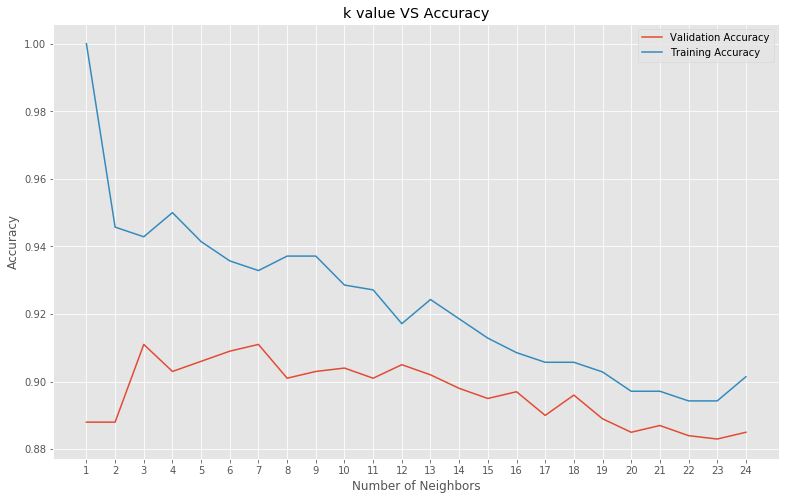

Best Accuracy without feature scaling: 0.9109999999999999
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [12]:
# Model complexity
neig = np.arange(1, 25)
kfold = 10
train_accuracy = []
val_accuracy = []
bestKnn = None
bestAcc = 0.0
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(knn.score(X_train, y_train))
    # test accuracy
    val_accuracy.append(np.mean(cross_val_score(knn, X, y, cv=kfold)))
    if np.mean(cross_val_score(knn, X, y, cv=kfold)) > bestAcc:
        bestAcc = np.mean(cross_val_score(knn, X, y, cv=10))
        bestKnn = knn

# Plot
plt.figure(figsize=[13,8])
plt.plot(neig, val_accuracy, label = 'Validation Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('k value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()

print('Best Accuracy without feature scaling:', bestAcc)
print(bestKnn)

In [14]:
# predict test
test_fill = np.nan_to_num(test)
submission = pd.DataFrame(bestKnn.predict(test_fill))
print(submission.shape)
submission.columns = ['Solution']
submission['Id'] = np.arange(1,submission.shape[0]+1)
submission = submission[['Id', 'Solution']]
submission.head()

(9000, 1)


,Id,Solution
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0


In [15]:
submission.to_csv('submission_no_normalization.csv', index=False)

## Add feature scaling

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

std = StandardScaler()
X_std = std.fit_transform(X)
mms = MinMaxScaler()
X_mms = mms.fit_transform(X)
norm = Normalizer()
X_norm = norm.fit_transform(X)

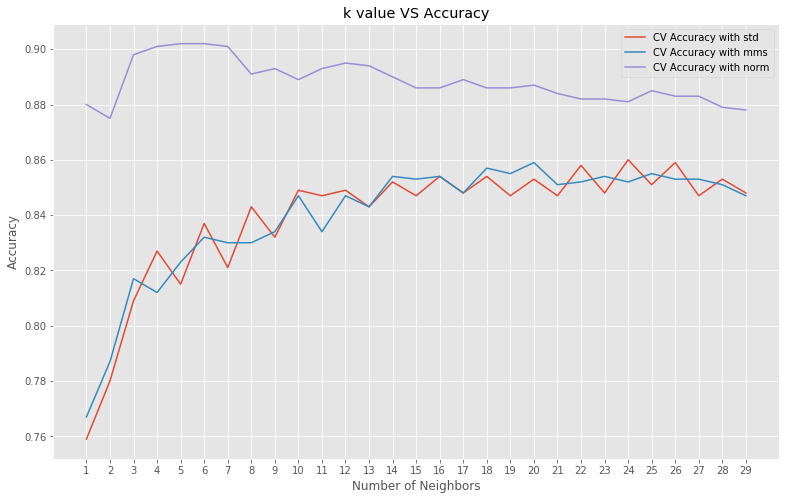

Best Accuracy with feature scaling: 0.9019999999999999
Best kNN classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Best scaling: norm


In [17]:
# Model complexity
neig = np.arange(1, 30)
kfold = 10
val_accuracy = {'std':[], 'mms':[], 'norm':[]}
bestKnn = None
bestAcc = 0.0
bestScaling = None
# Loop over different values of k
for i, k in enumerate(neig):
    knn = KNeighborsClassifier(n_neighbors=k)
    # validation accuracy
    s1 = np.mean(cross_val_score(knn, X_std, y, cv=kfold))
    val_accuracy['std'].append(s1)
    s2 = np.mean(cross_val_score(knn, X_mms, y, cv=kfold))
    val_accuracy['mms'].append(s2)
    s3 = np.mean(cross_val_score(knn, X_norm, y, cv=kfold))
    val_accuracy['norm'].append(s3)
    if s1 > bestAcc:
        bestAcc = s1
        bestKnn = knn
        bestScaling = 'std'
    elif s2 > bestAcc:
        bestAcc = s2
        bestKnn = knn
        bestScaling = 'mms'
    elif s3 > bestAcc:
        bestAcc = s3
        bestKnn = knn
        bestScaling = 'norm'

# Plot
plt.figure(figsize=[13,8])
plt.plot(neig, val_accuracy['std'], label = 'CV Accuracy with std')
plt.plot(neig, val_accuracy['mms'], label = 'CV Accuracy with mms')
plt.plot(neig, val_accuracy['norm'], label = 'CV Accuracy with norm')
plt.legend()
plt.title('k value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()

print('Best Accuracy with feature scaling:', bestAcc)
print('Best kNN classifier:', bestKnn)
print('Best scaling:', bestScaling)

In [18]:
# predict on test
bestKnn.fit(X_norm, y)
submission = pd.DataFrame(bestKnn.predict(norm.transform(test_fill)))
print(submission.shape)
submission.columns = ['Solution']
submission['Id'] = np.arange(1,submission.shape[0]+1)
submission = submission[['Id', 'Solution']]
submission.head()

(9000, 1)


,Id,Solution
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0


In [19]:
submission.to_csv('submission_with_scaling.csv', index=False)

## Feature Selection

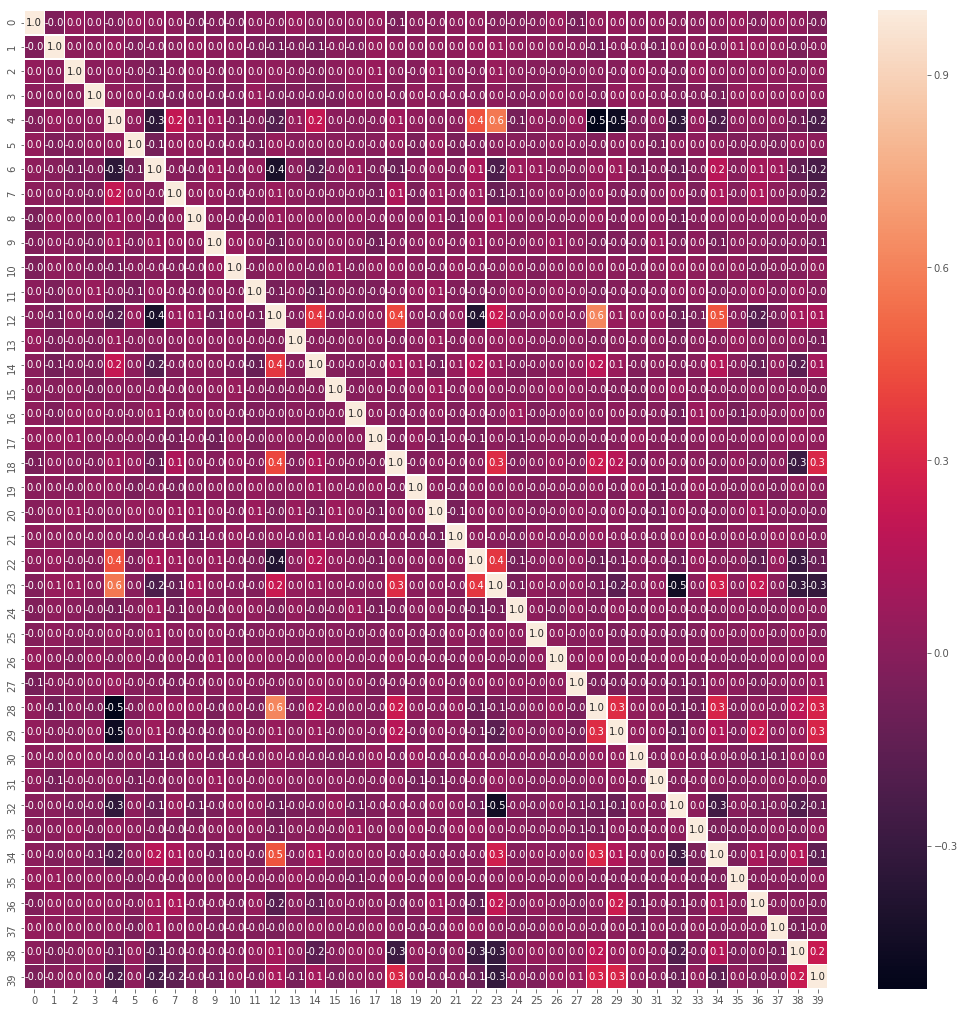

In [20]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pd.DataFrame(X_std).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Accuracy is:  0.8366666666666667


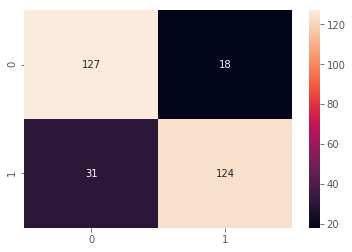

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and val 30 %
X_train, X_val, y_train, y_val = train_test_split(X_std, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_val,clf_rf.predict(X_val))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_val,clf_rf.predict(X_val))
sns.heatmap(cm,annot=True,fmt="d")

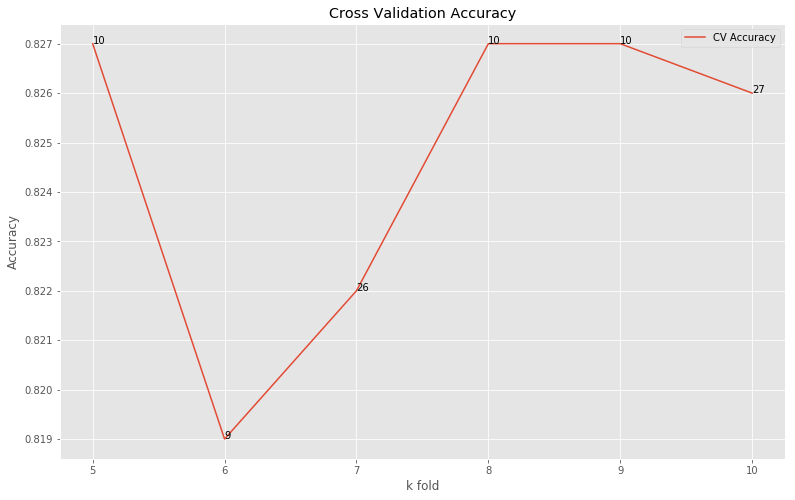

Best Accuracy with feature scaling and RFECV: 0.827


In [22]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

kfold = 10
bestSVC = None
bestAcc = 0.0
val_accuracy = []
cv_range = np.arange(5, 11)
n_feature = []
for cv in cv_range:
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear")
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=svc, step=1, cv=cv, scoring='accuracy')
    rfecv.fit(X_std, y)

    # print("Optimal number of features : %d" % rfecv.n_features_)
    # print('Best features :', pd.DataFrame(X_train).columns[rfecv.support_])

    # Model complexity
    val_accuracy += [np.mean(cross_val_score(svc, X_std[:, rfecv.support_], y, cv=kfold))]
    n_feature.append(rfecv.n_features_)
    if val_accuracy[-1] > bestAcc:
        bestAcc = val_accuracy[-1]

# Plot
plt.figure(figsize=[13,8])
plt.plot(cv_range, val_accuracy, label = 'CV Accuracy')
for i in range(len(cv_range)):
    plt.annotate(str(n_feature[i]), xy=(cv_range[i],val_accuracy[i]))
plt.legend()
plt.title('Cross Validation Accuracy')
plt.xlabel('k fold')
plt.ylabel('Accuracy')
plt.show()

print('Best Accuracy with feature scaling and RFECV:', bestAcc)

In [23]:
import numpy as np
#import sklearn as sk
#import matplotlib.pyplot as plt
import pandas as pd

#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import Perceptron
#from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import VotingClassifier
#from sklearn import svm

#### READING OUR GIVEN DATA INTO PANDAS DATAFRAME ####
x_train = train
y_train = trainLabel
x_test = test
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_train = y_train.ravel()
print('training_x Shape:',x_train.shape,',training_y Shape:',y_train.shape, ',testing_x Shape:',x_test.shape)

#Checking the models
x_all = np.r_[x_train,x_test]
print('x_all shape :',x_all.shape)

#### USING THE GAUSSIAN MIXTURE MODEL ####
from sklearn.mixture import GaussianMixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit(x_all)
        bic.append(gmm.aic(x_all))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
best_gmm.fit(x_all)
x_train = best_gmm.predict_proba(x_train)
x_test = best_gmm.predict_proba(x_test)


#### TAKING ONLY TWO MODELS FOR KEEPING IT SIMPLE ####
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

param_grid = dict( )
#### GRID SEARCH for BEST TUNING PARAMETERS FOR KNN #####
grid_search_knn = GridSearchCV(knn,param_grid=param_grid,cv=10,scoring='accuracy').fit(x_train,y_train)
print('best estimator KNN:',grid_search_knn.best_estimator_,'Best Score', grid_search_knn.best_estimator_.score(x_train,y_train))
knn_best = grid_search_knn.best_estimator_

#### GRID SEARCH for BEST TUNING PARAMETERS FOR RandomForest #####
grid_search_rf = GridSearchCV(rf, param_grid=dict( ), verbose=3,scoring='accuracy',cv=10).fit(x_train,y_train)
print('best estimator RandomForest:',grid_search_rf.best_estimator_,'Best Score', grid_search_rf.best_estimator_.score(x_train,y_train))
rf_best = grid_search_rf.best_estimator_


knn_best.fit(x_train,y_train)
print(knn_best.predict(x_test)[0:10])
rf_best.fit(x_train,y_train)
print(rf_best.predict(x_test)[0:10])

#### SCORING THE MODELS ####
print('Score for KNN :',cross_val_score(knn_best,x_train,y_train,cv=10,scoring='accuracy').mean())
print('Score for Random Forest :',cross_val_score(rf_best,x_train,y_train,cv=10,scoring='accuracy').max())

### IN CASE WE WERE USING MORE THAN ONE CLASSIFIERS THEN VOTING CLASSIFIER CAN BE USEFUL ###
#clf = VotingClassifier(
#		estimators=[('knn_best',knn_best),('rf_best',rf_best)],
#		#weights=[871856020222,0.907895269918]
#	)
#clf.fit(x_train,y_train)
#print clf.predict(x_test)[0:10]

##### FRAMING OUR SOLUTION #####
knn_best_pred = pd.DataFrame(knn_best.predict(x_test))
rf_best_pred = pd.DataFrame(rf_best.predict(x_test))
#voting_clf_pred = pd.DataFrame(clf.predict(x_test))

knn_best_pred.index += 1
rf_best_pred.index += 1
#voting_clf_pred.index += 1

rf_best_pred.columns = ['Solution']
rf_best_pred['Id'] = np.arange(1,rf_best_pred.shape[0]+1)
rf_best_pred = rf_best_pred[['Id', 'Solution']]
print(rf_best_pred)

#knn_best_pred.to_csv('knn_best_pred.csv')
rf_best_pred.to_csv('Submission_rf.csv', index=False)
#voting_clf_pred.to_csv('voting_clf_pred.csv')

training_x Shape: (1000, 40) ,training_y Shape: (1000,) ,testing_x Shape: (9000, 40)
x_all shape : (10000, 40)
best estimator KNN: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') Best Score 0.996
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] ...................................... , score=1.0, total=   0.0s
[CV]  ................................................................
[CV] ...................................... , score=1.0, total=   0.0s
[CV]  ................................................................
[CV] ...................................... , score=1.0, total=   0.0s
[CV]  ................................................................
[CV] ..................................... , score=0.99, total=   0.0s
[CV]  .....................................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Score for KNN : 0.9960000000000001
Score for Random Forest : 1.0
        Id  Solution
1        1         1
2        2         0
3        3         1
4        4         0
5        5         0
6        6         0
7        7         0
8        8         1
9        9         0
10      10         0
11      11         1
12      12         1
13      13         0
14      14         0
15      15         0
16      16         1
17      17         0
18      18         0
19      19         1
20      20         1
21      21         0
22      22         1
23      23         1
24      24         0
25      25         1
26      26         1
27      27         0
28      28         0
29      29         1
30      30         0
...    ...       ...
8971  8971         1
8972  8972         0
8973  8973         1
8974  8974         0
8975  8975         0
8976  8976         1
8977  8977         0
8978  8978         1
8979  8979         1
8980  8980         1
8981  8981         1
8982  8982         1
8983  8983 